In [4]:
import numpy as np
from numpy import pi
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import pandas as pd
import random
from qutip import *
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

%matplotlib inline

# CRAB optimization of asymmetric Szilard engine

This is a program to calculate optimal protocols that effectively split the quantum wavefunction of a single-particle-box in two equal halves, by inserting an off-center barrier. See https://doi.org/10.1103/PhysRevA.99.022121 for details.

## Import data to calculate stationary states

In [18]:
def interp_generator(a):

    max_lvl = 4 

    tab_alfa = np.loadtxt('/home/vegard/Split-wavefunction/data/alfa/alfa_a_' + "{:.3f}".format(a) + '.txt', delimiter = ',')        
    energies = np.loadtxt('/home/vegard/Split-wavefunction/data/energies/Energies_a_' + "{:.3f}".format(a) + '.txt', delimiter = ',')
    overlap = np.loadtxt('/home/vegard/Split-wavefunction/data/overlap/overlap_a_' + "{:.3f}".format(a)+ '.txt', delimiter = ',')

    overlap = np.reshape(overlap, [max_lvl,max_lvl,5001], order = 'F')

    interp_energy = [None]*max_lvl

    for n in range(max_lvl):
        f = interp1d(tab_alfa,energies[:,n], kind = 'cubic')
        interp_energy[n] = f

    interp_overlap = [[0] * max_lvl for i in range(max_lvl)]

    for n in range(max_lvl):
        for m in range(max_lvl):
            interp_overlap[n][m] = interp1d(tab_alfa,overlap[n,m,:], kind = 'cubic')

    return interp_energy, interp_overlap

## CRAB optimization

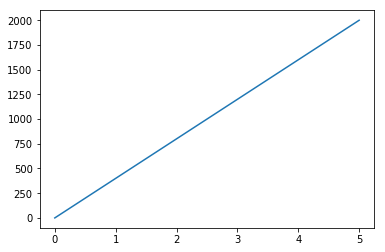

In [29]:
## Define time grid, and regularization function (for fixed boundary conditions)

t_max = 5.0
dt = 1e-2
N_t = int(t_max/dt)

time = np.linspace(0,t_max,N_t)

reg = np.sin(time*pi/(t_max))**2

asymmetry = 0.530
interp_energy, interp_overlap = interp_generator(asymmetry)

## Generate initial guess protocol to improve upon
max_lvl = 4
alfa_max = 2000.0
max_alfa = 3000.0

a = alfa_max/t_max

alfa_guess = a*time

## Choose number of terms in the Fourier expansion and generate protocol alfa

N_c = 10
A = np.zeros(N_c)*0.5
B = np.zeros(N_c)*0.5
w = np.zeros(N_c)*0.5
x0 = np.append(A,np.append(B,w))

fourier = sum([A[n]*np.cos(w[n]*time) + B[n]*np.sin(w[n]*time) for n in range (N_c)])

alfa = alfa_guess*( 1 + reg*fourier )

plt.plot(time,alfa)

## Use either Nelder-Mead or Powell's method to minimize the cost function

In [1]:
res_nm = minimize(Szilard, x0, method='nelder-mead') 

In [2]:
res_pow = minimize(Szilard, x0, method='Powell')

## Environment function

This function takes the fourier coefficients as input, uses them to solve the Shrødinger equation for the associated protocol, thus obtaining the final probability distribution of the energy eigenstates. These final eigenstates is used to determine the value of a cost function that we want to minimize, whose value is given as an output for the Nelder-Mead or Powell's method.

In [33]:
def Szilard(x):
        
    A = x[0:N_c]
    B = x[N_c:2*N_c]
    w = x[2*N_c:3*N_c]
    
    #print(A, B, w)
    
    fourier = sum([A[n]*np.cos(w[n]*time) + B[n]*np.sin(w[n]*time) for n in range (N_c)])
    
    noise = np.array([np.random.normal(0,0) for n in range (N_t)])

    alfa = abs(alfa_guess*( 1 + reg*fourier ) + noise )
    


    ## CALCULATE TIME DEPENDENCE OF ENERGY FOR GIVEN PROTOCOL

    E = []

    for t in range(N_t):
        E.append([interp_energy[n](alfa[t]) for n in range(max_lvl)])

    E = np.array(E)
    E.shape

    ## CALCULATE PHASE

    phi = []

    for t in range(N_t):

            integral = [np.trapz(x=time[0:t+1], y= E[0:t+1,n]) for n in range(max_lvl)]

            phi.append(integral)  

    phi = np.array(phi)   

    def interaction(n, alfa, f = []):
        test = sum([interp_overlap[n][m](alfa)*np.exp(1j*(phi[t,n] - phi[t,m]) )*f[m] for m in range(max_lvl) if m != n ])*dalfa
        return test


    ## SOLVE DIFFERENTIAL EQUATION WITH RK4

    C = np.array([ 0 for n in range(max_lvl) ])
    C[0] = 1
    C_new = np.array( [ 0 for n in range(max_lvl) ])
    C_t = []
    C_t.append(C)

    for t in range(N_t -1):

        dalfa = (alfa[t+1] - alfa[t])/dt

        k1 = np.array([dt*interaction(n, alfa[t], C ) for n in range(max_lvl)])
        k2 = np.array([dt*interaction(n, alfa[t]+ dalfa*dt/2, C + k1/2 ) for n in range(max_lvl)])
        k3 = np.array([dt*interaction(n, alfa[t]+ dalfa*dt/2, C + k2/2 ) for n in range(max_lvl)])
        k4 = np.array([dt*interaction(n, alfa[t]+ dalfa*dt, C + k3) for n in range(max_lvl)])

        C_new = C + (k1 + 2*k2 + 2*k3 + k4)/6

        C = C_new
        
        C_t.append(C)

    C_t = np.array(C_t)
    
    c1 = abs(C[0])**2
    c2 = abs(C[1])**2
    sigma = 0.05
    
    leakage = sum( abs(C[n])**2 for n in range(2,max_lvl)  )
    punishment = 1 - np.exp( -((c1-0.5)**2 + (c2-0.5)**2)/(sigma))
    
    print('c1: {}, c2: {}, punishment: {}'.format(c1,c2,punishment))
    #plt.plot(time,alfa)
    
    return punishment

## Test how well the protocol performs on asymmetries that it has not been optimized for.

In [ ]:
leakage = [0 for n in range (51,61)]
asymmetry = [0 for n in range (51,61)]
punishment = [0 for n in range (51,61)]

k = 0
for n in range (51,61):
    asymmetry[k] = round(0.01*n,2)
    print(asymmetry)
    interp_energy, interp_overlap = interp_gen(asymmetry[k])
    punishment[k], leakage[k] = Szilard(test)
    
    k +=1
    
plt.plot(asymmetry,punishment)